## Figures for analysis of the T-cell dataset
This notebook reproduces Figures 5E-G, 6C, S5A, S6B, S6D-G, S6I 


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
from copy import deepcopy
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from scipy import stats
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from sklearn.decomposition import NMF
import itertools

<h3> Load data </h3>

In [1]:
out_dir = '../out.tcell.060121/'

In [4]:
### Can be downloaded at https://data.humantumoratlas.org/
adata = sc.read(out_dir + 'adata.tcell.010920.h5ad')


Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


In [16]:
# Load cell type proportion and sample covariates
proportions_ct_fine = pd.read_csv(out_dir + 'celltypeComposition.tcell.010920.txt', sep = '\t', index_col = 0)
sample_covariates = pd.read_csv(out_dir + 'sampleCovariates.tcell.010920.txt', sep = '\t', index_col = 0)


In [19]:
#Load vectra
df_final_filter = pd.read_csv(out_dir + 'vectra/vectra.N+_vs_N-.csv',
                             sep = '\t')
df_feature = pd.read_csv(out_dir + 'vectra/vectra.feature_matrix.csv',index_col=0)

### Figure 5E

In [9]:
# Function to regress out covariates from variables before performing spearman correlation
def regress_cov(X,y, cov):
    cvar = np.atleast_2d(cov)
    beta_x = np.linalg.lstsq(cvar, X, rcond=None)[0]
    beta_y = np.linalg.lstsq(cvar, y, rcond=None)[0]
    res_x = X - np.dot(cvar, beta_x)
    res_y = y - np.dot(cvar, beta_y)
    return res_x, res_y

def partial_cor(X,y, cov):
    cvar = np.atleast_2d(cov)
    beta_x = np.linalg.lstsq(cvar, X, rcond=None)[0]
    beta_y = np.linalg.lstsq(cvar, y, rcond=None)[0]
    res_x = X - np.dot(cvar, beta_x)
    res_y = y - np.dot(cvar, beta_y)
    return spearmanr(res_x, res_y)



In [10]:
# Merge technical replicates
adata.obs['batch'] = np.array(adata.obs['batch'])
adata.obs.loc[adata.obs['batch'].str.contains('RU1108'),'batch'] = 'RU1108a'


In [11]:
# Compute covariate-adjusted factor ratio per sample
adata.obs['NMF_Treg'] = adata.obsm['nmf_cell_loadings'][:,4]
adata.obs['NMF_CD8_Eff'] = adata.obsm['nmf_cell_loadings'][:,28]

## Compute factor ratio
nmf_ratio = pd.DataFrame(np.log2(adata.obs.groupby('batch')['NMF_CD8_Eff'].mean()+0.0001) \
                         -np.log2(adata.obs.groupby('batch')['NMF_Treg'].mean()+0.0001))

## Perform covariate adjusted partial regression between factors X and y
X = nmf_ratio.loc[sample_covariates.index].fillna(0)
y = nmf_ratio.loc[sample_covariates.index].fillna(0)
cov = pd.get_dummies(sample_covariates[['treatment','tissue']])[['treatment_Platinum Doublet',
                                                                 'treatment_Platinum Doublet,Immunotherapy',
                                                                 'treatment_TMZ','tissue_LN', 'tissue_distant']]
x_res, y_res = regress_cov(X,y,cov)


In [12]:
from statsmodels.stats.weightstats import ttest_ind

In [13]:
# Perform weighted t test on covariate adjusted factor ratio
ratio = pd.DataFrame(y_res.values.T[0])
ratio['subtype'] = sample_covariates['histology_subtype'].values
ratio.index = sample_covariates.index

samples_a = sample_covariates.index[sample_covariates.histology_subtype=='SCLC-A']
samples_n = sample_covariates.index[sample_covariates.histology_subtype=='SCLC-N']

num_samples_a, num_samples_n = len(samples_a), len(samples_n)
num_cells_a, num_cells_n = adata.obs.batch.isin(samples_a).sum(), adata.obs.batch.isin(samples_n).sum()

weights_a = pd.DataFrame((pd.DataFrame(adata.obs['batch'].value_counts()).loc[samples_a].values \
                          * num_samples_a / num_cells_a).T[0], 
                         index = samples_a)
weights_n = pd.DataFrame((pd.DataFrame(adata.obs['batch'].value_counts()).loc[samples_n].values \
                          * num_samples_n / num_cells_n).T[0], 
                         index = samples_n)

_,pval,_ = ttest_ind(ratio[0][ratio['subtype']=='SCLC-A'].values,
                     ratio[0][ratio['subtype']=='SCLC-N'].values, alternative='larger', 
                     usevar='unequal', 
                     weights = (weights_a.loc[ratio.index[ratio['subtype']=='SCLC-A']][0].values,
                                weights_n.loc[ratio.index[ratio['subtype']=='SCLC-N']][0].values))


(array([0, 1]), [Text(0, 0, 'SCLC-A'), Text(1, 0, 'SCLC-N')])

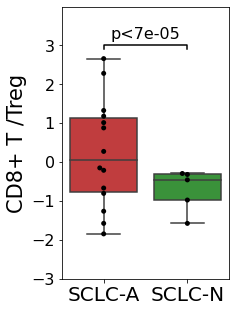

In [14]:
# Plot CD8/Treg factor ratio stratified by SCLC subtype
plt.rcParams['figure.figsize'] = [3, 5]
ratio = pd.DataFrame(y.values.T[0])
ratio['subtype'] = sample_covariates['histology_subtype'].values
ratio.index = sample_covariates.index
ratio = ratio.loc[ratio.subtype!='SCLC-P',:]
sns.boxplot(y = 0, x = 'subtype', data = ratio, palette = ['tab:red','tab:green'])
sns.swarmplot(y = 0, x = 'subtype', data = ratio, color = 'black')
plt.ylim(-3,3.99)
plt.text(0.5, 3.1, 'p<{:.0e}'.format(pval), ha='center', va='bottom',fontsize=16)
plt.plot([0,0,1,1], [2.9,3,3,2.9], lw=1.5, color = 'black')
plt.ylabel('CD8+ T /Treg', fontsize = 21)
plt.xlabel('',fontsize=1)
plt.yticks(size = 16)
plt.xticks(size = 20)


### Figure 5F

In [20]:
N_plus_df = df_final_filter.loc[df_final_filter.NEUROD1_status == 'NEUROD1+',:]
N_minus_df = df_final_filter.loc[df_final_filter.NEUROD1_status == 'NEUROD1-',:]


In [21]:
_,pval,_ = ttest_ind(np.log2(N_plus_df['CD8/FOXP3 ratio']),
          np.log2(N_minus_df['CD8/FOXP3 ratio']),
          alternative='smaller',
          weights=((N_plus_df['immune_number']*len(N_plus_df)/np.sum(N_plus_df['immune_number'])).values,
                   (N_minus_df['immune_number']*len(N_minus_df)/np.sum(N_minus_df['immune_number'])).values))

In [22]:
df_final_filter.loc[:,'CD8/FOXP3 log ratio'] = np.log2(df_final_filter.loc[:,'CD8/FOXP3 ratio'])

(array([0, 1]), [Text(0, 0, 'SCLC N-'), Text(1, 0, 'SCLC N+')])

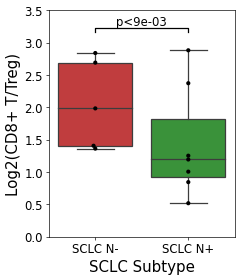

In [23]:
plt.figure(figsize=(4,5),dpi=60)
ax=sns.boxplot(y = 'CD8/FOXP3 log ratio', x = 'NEUROD1_status', order=['NEUROD1-','NEUROD1+'],data = df_final_filter, palette = ['tab:red','tab:green'])
sns.swarmplot(y = 'CD8/FOXP3 log ratio', x = 'NEUROD1_status', order=['NEUROD1-','NEUROD1+'], data = df_final_filter, color = 'black')
ax.set_xticklabels(['SCLC N-','SCLC N+'],rotation=0)
plt.ylim(0,3.5)
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_final_filter['CD8/FOXP3 log ratio'].max()*1.1, df_final_filter['CD8/FOXP3 log ratio'].max()*0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, 'p<{:.0e}'.format(pval), ha='center', va='bottom', color=col,fontsize=14)

plt.ylabel('Log2(CD8+ T/Treg)', fontsize = 18)
plt.xlabel('SCLC Subtype',fontsize=18)
plt.yticks(size = 14)
plt.xticks(size = 14)


### Figure 5G

In [24]:
import matplotlib.markers as mmarkers

def mscatter(x,y,ax=None, m=None, **kw):
    if not ax: 
        ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [25]:
image_list = list(set(df_feature.image_id))

In [26]:
subtype_df = df_final_filter.loc[:,['vectra_id','NEUROD1_status']]
subtype_df = subtype_df.loc[~subtype_df.duplicated(),:].set_index('vectra_id')

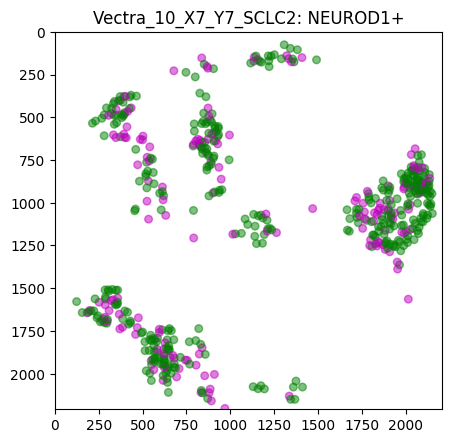

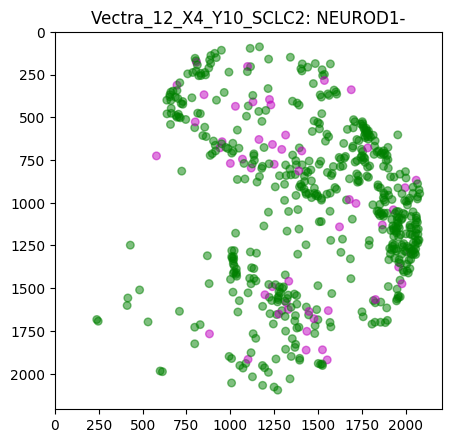

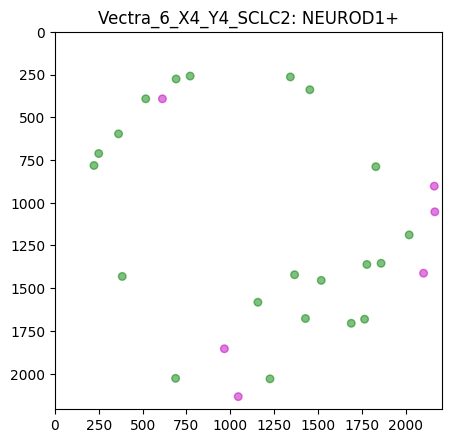

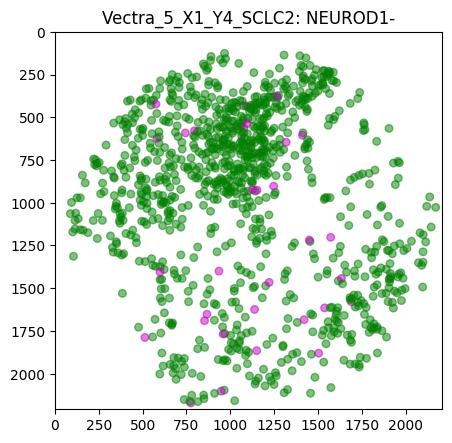

In [27]:
fov_diameter = 2208

for i in range(len(image_list)):
    ind_select = df_feature['image_id']==image_list[i]
    cell_img = df_feature[ind_select]
    subtype = subtype_df.loc[cell_img.sample_name.iloc[0]].iloc[0]
    Xs = cell_img['centroid_x'].astype('int').values
    Ys = cell_img['centroid_y'].astype('int').values
    target_index = (cell_img['FOXP3']) | (cell_img['CD8'])
    cell_img_new=cell_img[target_index]
    Xs = Xs[target_index]
    Ys = Ys[target_index]
    Cs = ['white' for x in range(len(Xs))]
    Cs = ['m' if (cell_img_new['FOXP3'].astype('int').values[i]) else x for i,x in enumerate(Cs)]
    Cs = ['green' if (cell_img_new['CD8'].astype('int').values[i]) else x for i,x in enumerate(Cs)]

    plt.figure(figsize=(int(fov_diameter/400),int(fov_diameter/400)),dpi=100)
    mscatter(Ys,Xs,s=30,c=Cs,alpha=0.5)

    plt.ylim(fov_diameter, 0)
    plt.xlim(0, fov_diameter)
    plt.title('%s: %s' % (image_list[i],subtype))


### Figure 6C

In [45]:
sc.set_figure_params(fontsize=12)

In [46]:
W = pd.DataFrame(zscore(adata.varm['nmf_gene_loadings'].T,axis=1), columns = adata.var_names)
W.index.name = 'Loadings'

In [51]:
adata2 = sc.AnnData(W)

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [52]:
ct_dict = {
    'T-cell\nmarkers': ['CD3E','TRAC','CD4','CD8A'],
    'CD4+\nTconv': ['LTB', 'SPOCK2', 'SOCS3', 'PBXIP1'], 
    'Treg': ['FOXP3', 'TNFRSF4', 'CARD16', 'IL2RA','TBC1D4'],
    'CD8+\nT-cells': ['CCL4', 'CST7', 'GZMA', 'GZMH'], 
    'Exhaustion': ['CTLA4', 'LAG3', 'PTMS','PDCD1', 'TIGIT'],
    'Memory-like': ['CD44','GZMK', 'IL7R','CD69','CD27'], 
    'LN-tropism': ['CCR7', 'SELL'], 
    'Tissue-resident': ['ITGAE'],
    'Effector-like': ['CTSW', 'PRF1','GZMB','FGFBP2','FCGR3A','TRGC2', 'GNLY',],
    'Tgd': ['TYROBP', 'FCER1G',  'CMC1','KLRD1','KLRG1','KLRF1', 'TRDC',], 
}

gene_list = list(itertools.chain.from_iterable(list(ct_dict.values())))
ct_pos = [[i for i,j in enumerate(gene_list) if j in val] for val in ct_dict.values()]
ct_pos = [(i[0],i[0]) if len(i)==1 else (i[0],i[-1]) for i in ct_pos]


In [53]:
adata2.obs.loc[:,'NMF'] = adata2.obs.index

In [54]:
adata2.obs.NMF = adata2.obs.NMF.astype(int).astype('category') 

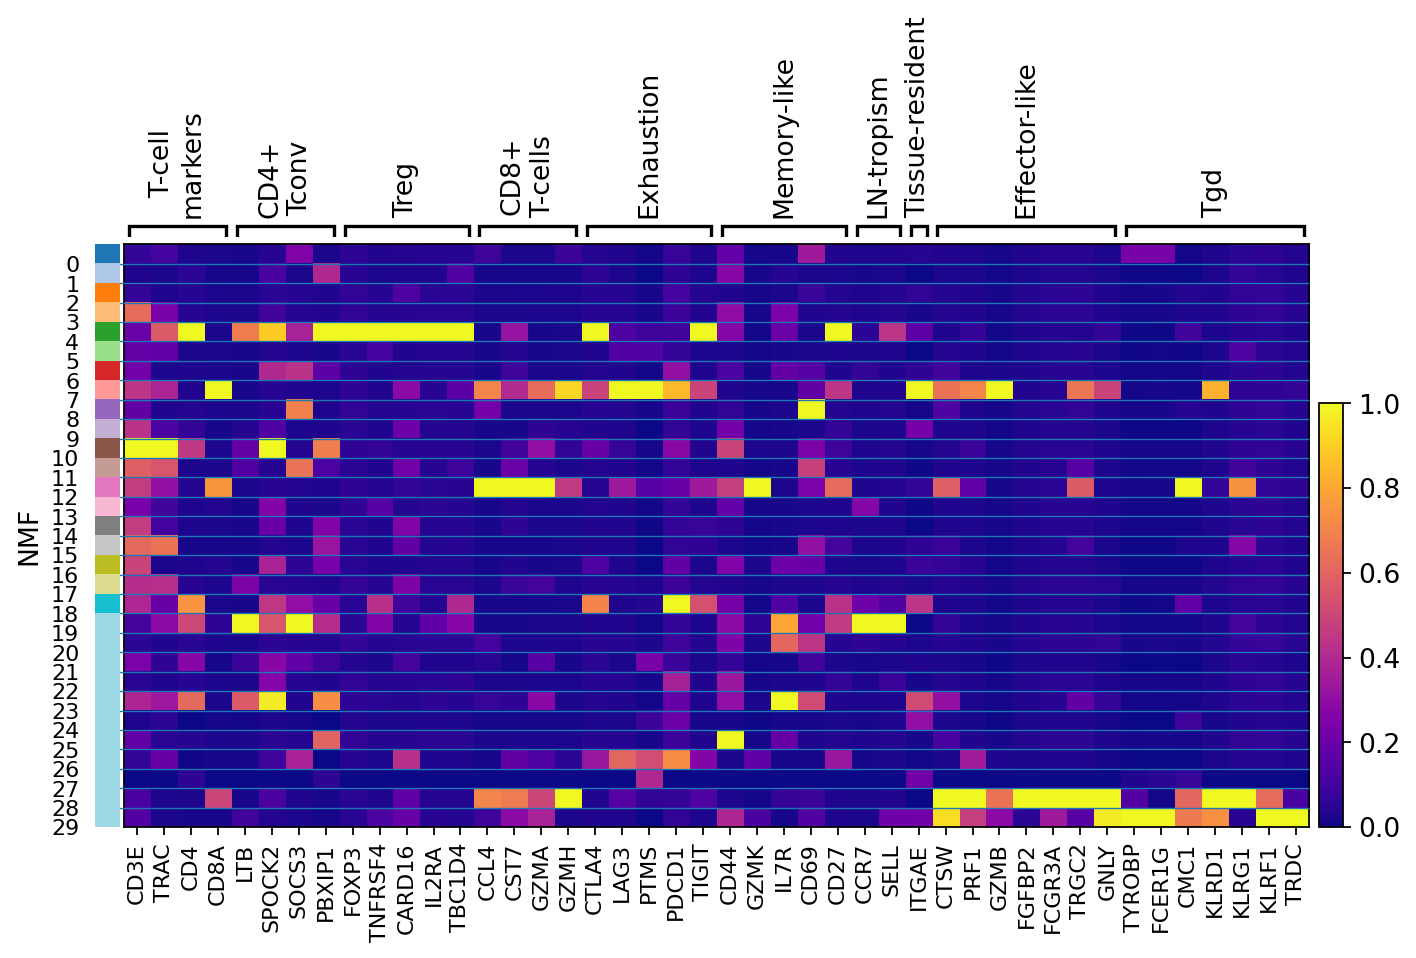

In [55]:
import itertools
ax = sc.pl.heatmap(adata2, gene_list, groupby='NMF', 
                   var_group_positions=ct_pos, 
                   use_raw = False,
                   var_group_labels=list(ct_dict.keys()), standard_scale='var',
                   cmap = 'plasma',
                   figsize=(10,5))



In [56]:
factors_interest = {4: 'Tregs',
                    7: 'Exhausted',
                    12: 'Memory-like',
                    19: 'Tconv',
                    23: 'Tconv',
                    28: 'Effector-like',
                    29: 'Tgd'
                   }


In [57]:
adata3 = adata2[list(factors_interest.keys()),:]

In [58]:
adata3.obs.NMF = ['%d: %s' % x for x in factors_interest.items()]


Trying to set attribute `.obs` of view, copying.


In [59]:
adata3.obs.NMF = adata3.obs.NMF.astype('category')

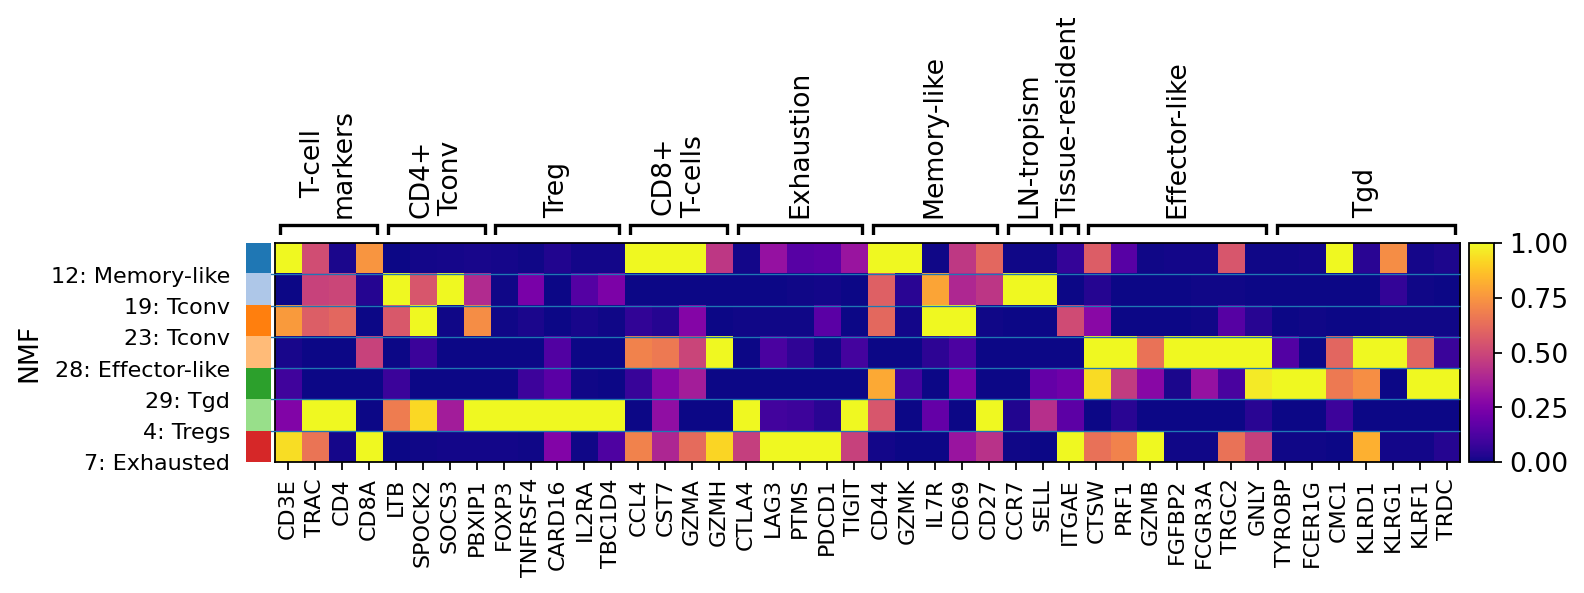

In [60]:
import itertools
ax = sc.pl.heatmap(adata3, gene_list, groupby='NMF', 
                   var_group_positions=ct_pos, 
                   use_raw = False,
                   var_group_labels=list(ct_dict.keys()), standard_scale='var',
                   cmap = 'plasma',
                   figsize=(10,2)) 



### Figure S5A

In [61]:
import palettable

In [62]:
col1 = palettable.colorbrewer.qualitative.Paired_3.mpl_colors[:2]
col2 = palettable.colorbrewer.qualitative.Paired_8.mpl_colors[-1:]
col3 = palettable.colorbrewer.qualitative.Paired_6.mpl_colors[-1:]
col4 = palettable.colorbrewer.qualitative.Paired_7.mpl_colors[-1:]
col5 = palettable.colorbrewer.qualitative.Paired_9.mpl_colors[-1:]

In [63]:
adata.obs.cell_type = adata.obs.cell_type.astype(str)
adata.obs.cell_type = adata.obs.cell_type.str.replace(' Eff.*','eff')
adata.obs.cell_type = adata.obs.cell_type.str.replace(' Exh.*','exh')
adata.obs.cell_type = adata.obs.cell_type.str.replace(' Mem.*','mem')
adata.obs.cell_type = adata.obs.cell_type.astype('category')


... storing 'batch' as categorical


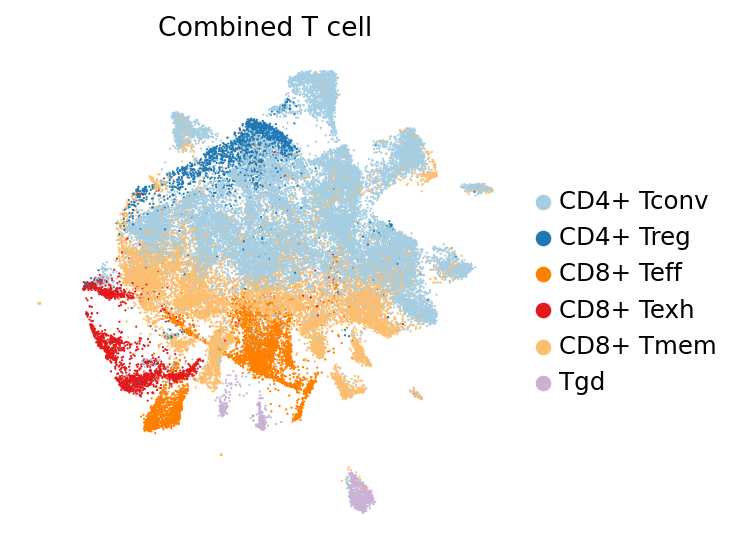

In [64]:
sc.pl.umap(
    adata, 
    color= 'cell_type',
    ncols=2, size=4,
    palette= col1 + col2 + col3 + col4 + col5,
    legend_fontoutline=2, title = 'Combined T cell' ,
    frameon=False
)

### Figure S6A

In [66]:
nmf_recon_dict = {}
for k in [3,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]:
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(np.log2(adata.layers['normalized']*10+1))
    H = model.components_
    nmf_dict[k] = model
    nmf_W_dict[k] = W
    nmf_H_dict[k] = H
    nmf_recon_dict[k] = model.reconstruction_err_

# This will take about an hour to run. Below is the reconstruction error we obtained.
# nmf_recon_dict = {3:33511,
#                   5: 33251.4005709757,
#  10: 33095.86947037349,
#  15: 32972.735403663435,
#  20: 32893.12827932302,
#  25: 32828.11672941352,
#  30: 32774.7785957434,
#  35: 32728.670733777137,
#  40: 32685.460498515236,
#  45: 32646.588550719967,
#  50: 32612.073347151665,
#  60: 32545.88391793961,
#  70: 32486.226004262175,
#  80: 32426.140565907623,
#  90: 32366.09386379518,
#  100: 32307.66893479008}

In [69]:
sns.set_style('ticks')

Text(46, 15.025, 'k = 30')

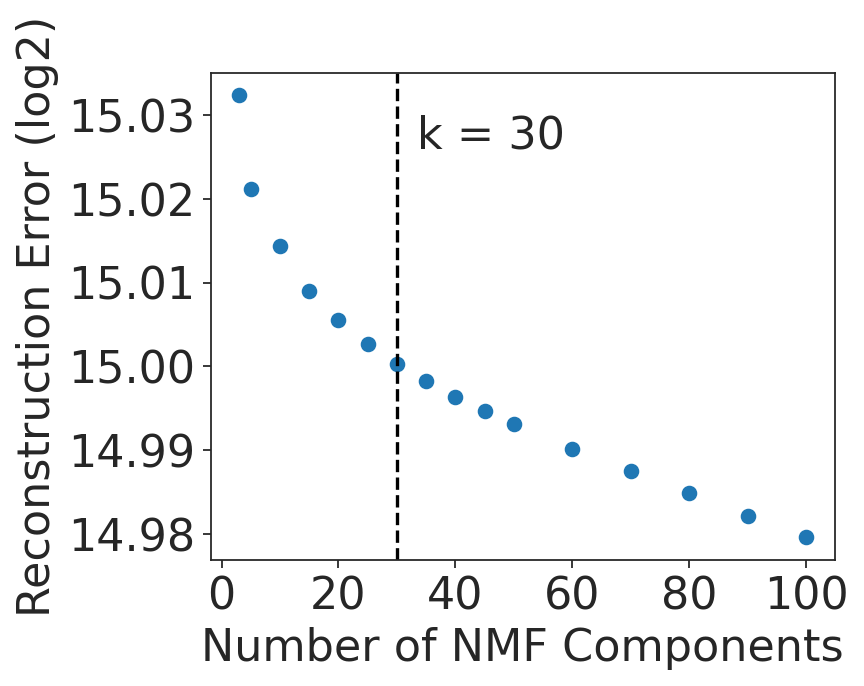

In [70]:
plt.rcParams['figure.figsize'] = [5, 4]

plt.scatter(pd.DataFrame(nmf_recon_dict, index = [0]).columns, 
            np.log2(pd.DataFrame(nmf_recon_dict, index = [0]).loc[0]))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Reconstruction Error (log2)', fontsize=20)
plt.xlabel('Number of NMF Components', fontsize=20)
plt.axvline(x = 30, linestyle = '--', color='black')

plt.text(46, 15.025, 'k = 30', ha='center', va='bottom',fontsize=20)


### Figure S6B

In [38]:
# THIS CAN TAKE A LONG TIME / CAN LOAD FROM THE PICKLE FILES BELOW
# for k in [24,26,28,30,32,34,36]:
#     model = NMF(n_components=k, init='random', random_state=0)
#     W = model.fit_transform(np.log2(adata.layers['normalized']*10+1))
#     H = model.components_
#     nmf_dict[k] = model
#     nmf_W_dict[k] = W
#     nmf_H_dict[k] = H
    

In [71]:
nmf_W_dict = pickle.load(open(out_dir + 'nmf/tcell_nmf_W_dict.robustness.p','rb'))
nmf_H_dict = pickle.load(open(out_dir + 'nmf/tcell_nmf_H_dict.robustness.p','rb'))

In [72]:
a = nmf_W_dict[30]

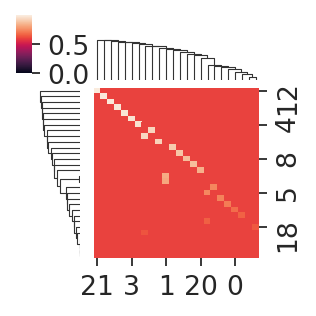

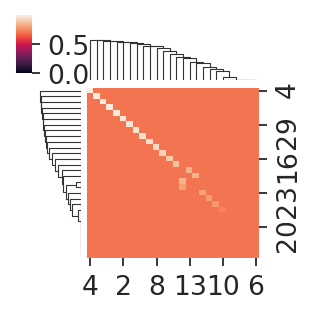

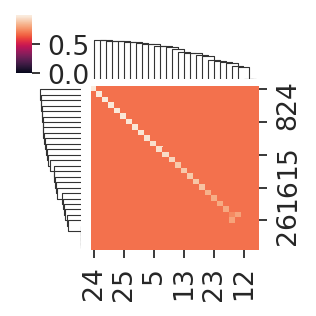

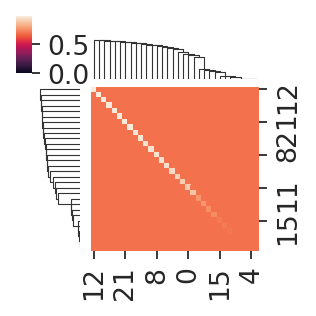

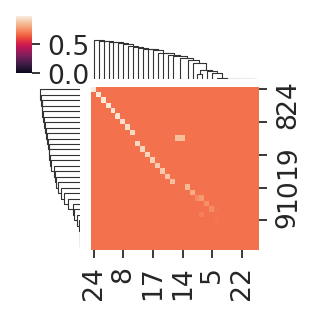

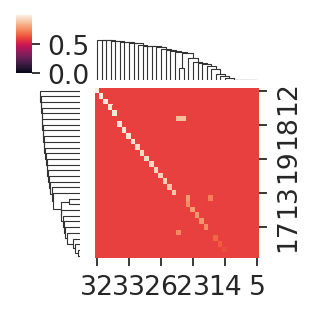

In [73]:
s_dict={}
clip_list = [0.6,0.7,0.7,0.7,0.7,0.6]
for k, clip in zip([24, 26, 28, 32, 34, 36], clip_list):
    b = nmf_W_dict[k]
    s_dict[k] = sns.clustermap(np.corrcoef(np.vstack((a.T,b.T)))[0:30,30:].clip(clip,1), figsize=(2,2), metric='euclidean', vmin = 0)


Text(0.5, 0.98, 'Pearson correlation between\n NMF factor loadings')

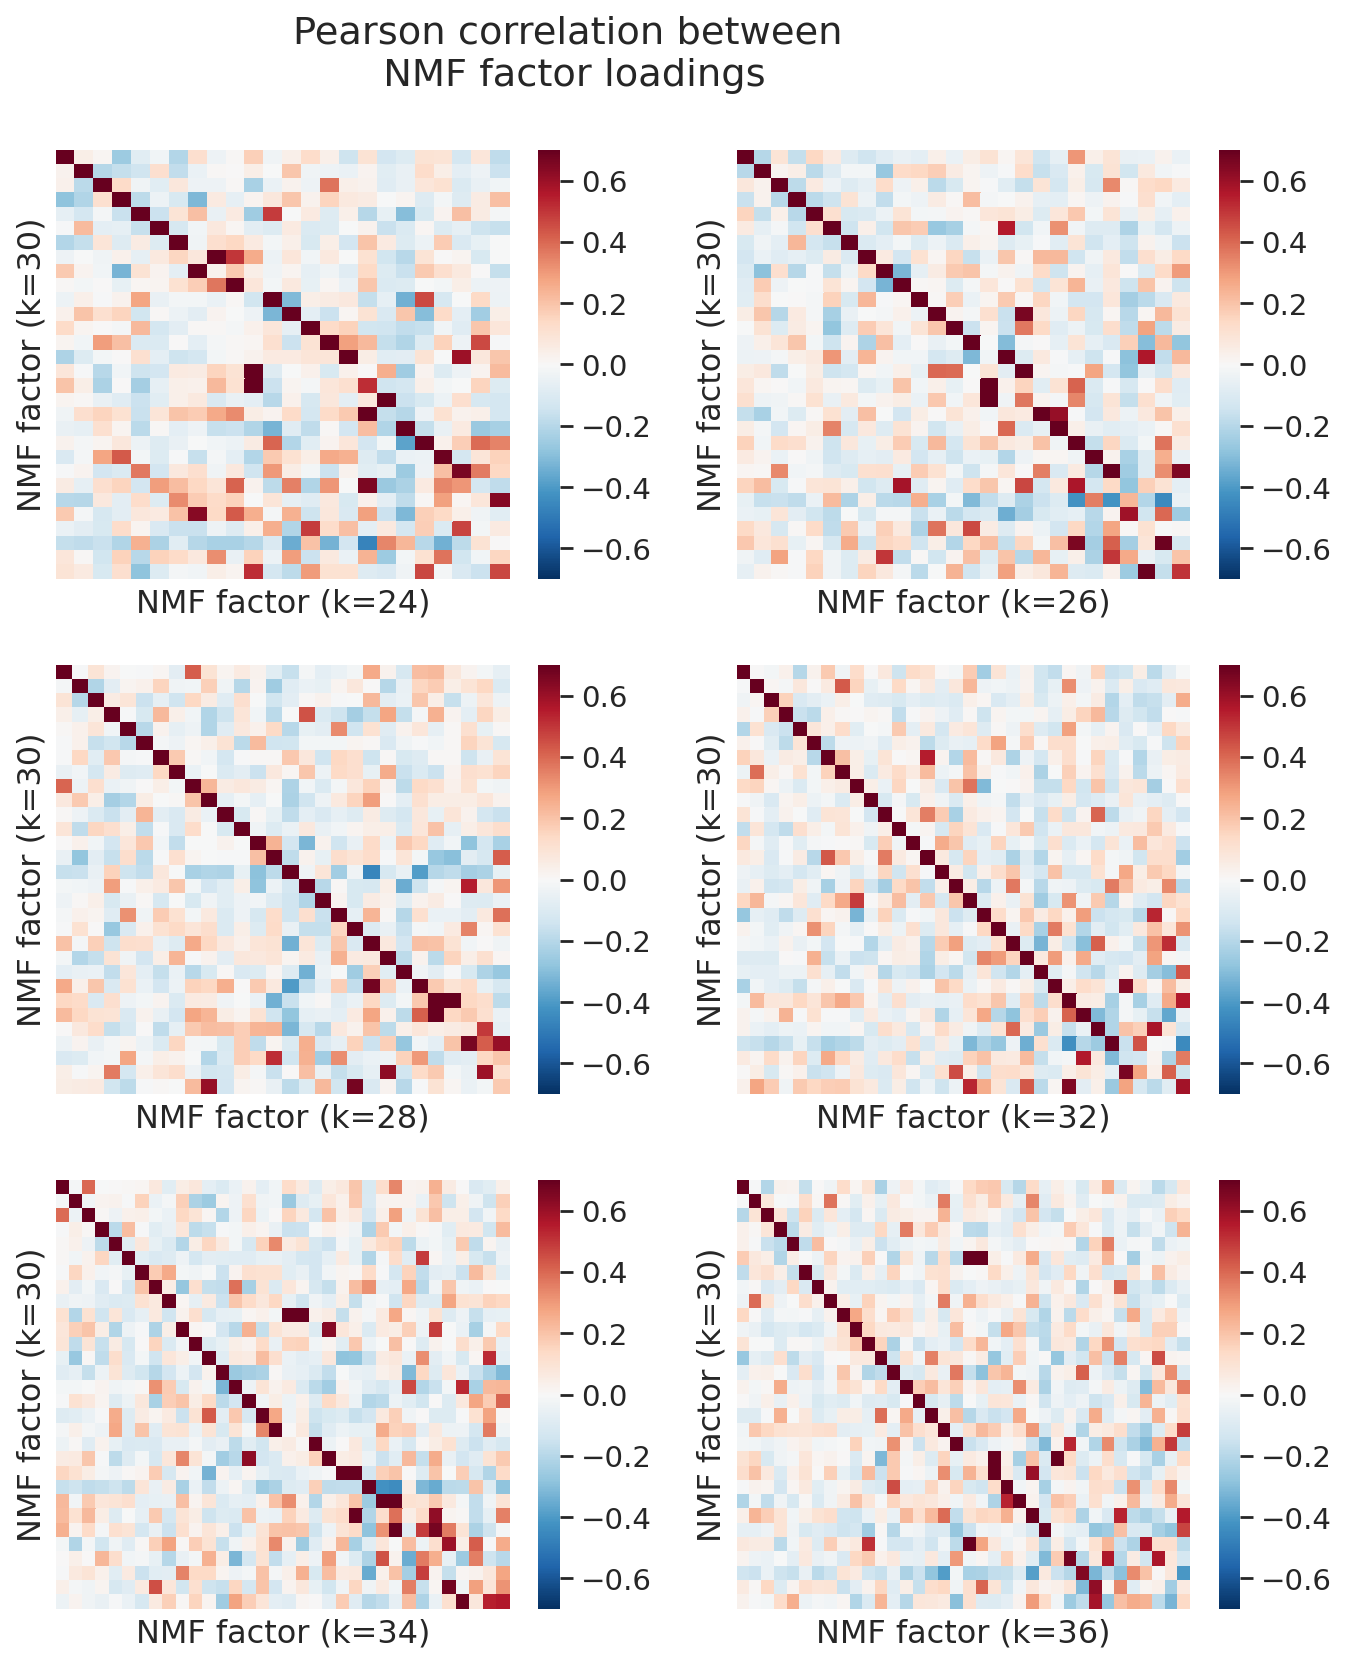

In [74]:
sns.set(font_scale=1.2)

fig, axes = plt.subplots(3,2, figsize=(10,12))

for k, ax in zip([24, 26, 28, 32, 34, 36], np.ravel(axes)):
    s = s_dict[k]

    b = nmf_W_dict[k]
    
    sns.heatmap(np.corrcoef(np.vstack((a.T,b.T)))[0:30,30:][s.dendrogram_row.reordered_ind][:,s.dendrogram_col.reordered_ind], 
                vmax = 0.7, vmin = -0.7, cmap = 'RdBu_r', xticklabels=False, yticklabels=False,ax=ax)
    ax.tick_params(left=False, bottom=False)
    ax.set_ylabel('NMF factor (k=30)')
    ax.set_xlabel('NMF factor (k={})'.format(k))
    
plt.suptitle('Pearson correlation between\n NMF factor loadings')


### Figure S6D-E

In [75]:
ct_dict = {
    'T-cell\nmarkers': ['CD3E','TRAC','CD4','CD8A'],
    'CD4+\nTconv': ['LTB', 'SPOCK2', 'SOCS3', 'PBXIP1'], #,'CCR6'
    'Treg': ['FOXP3', 'TNFRSF4', 'CARD16', 'IL2RA','TBC1D4'],
    'CD8+\nT-cells': ['CCL4', 'CST7', 'GZMA', 'GZMH'], #,'CD226' 
    'Exhaustion': ['CTLA4', 'LAG3', 'PTMS','PDCD1', 'TIGIT',], #'EOMES','TBX21','ENTPD1',
    'Memory-like': ['CD44','GZMK', 'IL7R','CD69','CD27'], #'ITGAE','IL2RB',
    'LN-tropism': ['CCR7', 'SELL'], 
    'Tissue-resident': ['ITGAE'],
    'Effector-like': ['CTSW', 'PRF1','GZMB','FGFBP2','FCGR3A','TRGC2', 'GNLY',], #,'MKI67'
    'Tgd': ['TYROBP', 'FCER1G',  'CMC1','KLRD1','KLRG1','KLRF1', 'TRDC',], #,'NCR2','NCR3'    
}

import itertools
gene_list = list(itertools.chain.from_iterable(list(ct_dict.values())))
ct_pos = [[i for i,j in enumerate(gene_list) if j in val] for val in ct_dict.values()]
ct_pos = [(i[0],i[0]) if len(i)==1 else (i[0],i[-1]) for i in ct_pos]

In [76]:
sc.set_figure_params(fontsize=12)

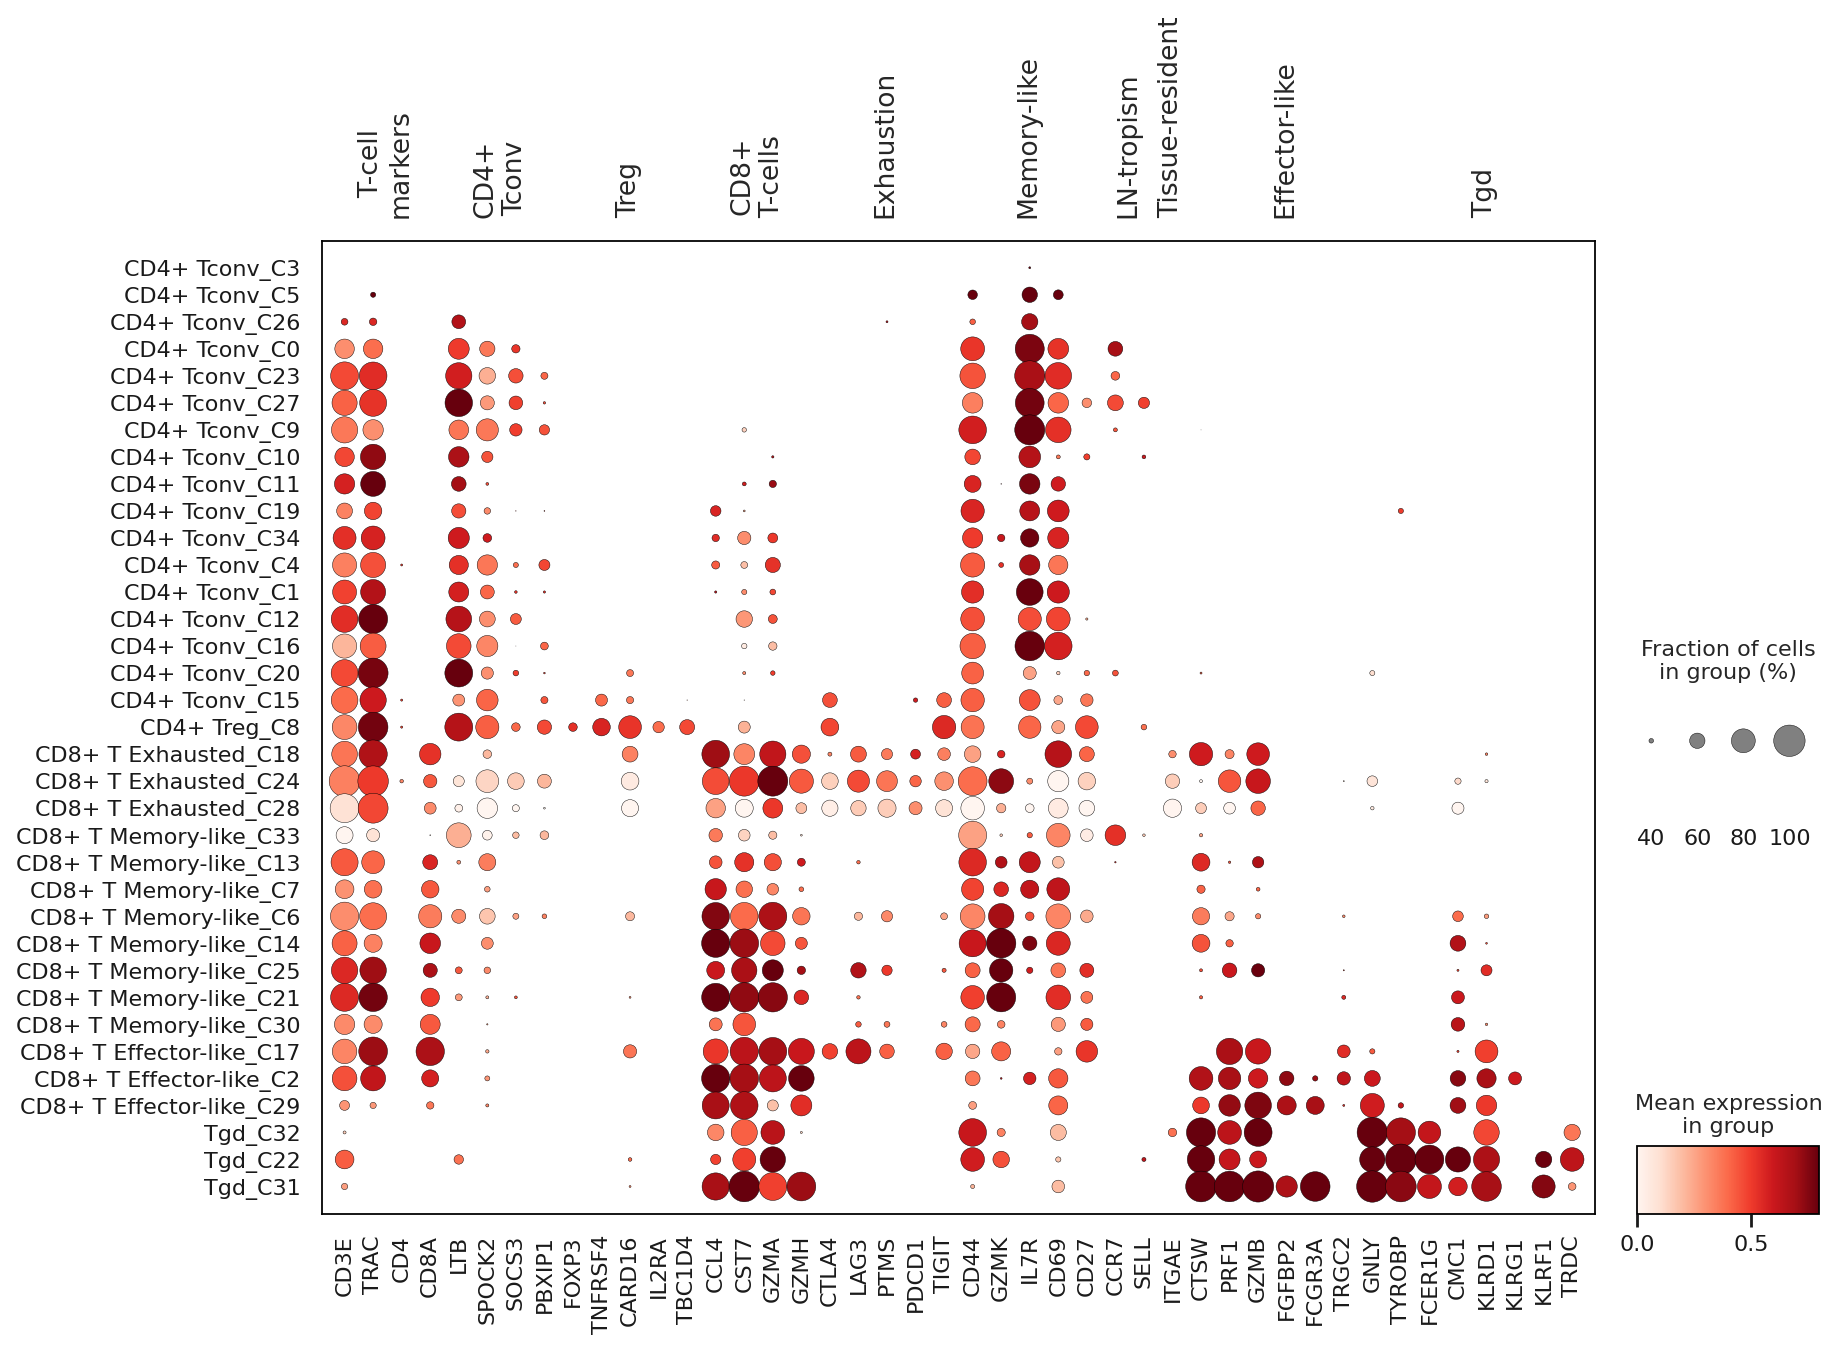

In [78]:
ax = sc.pl.dotplot(adata, gene_list, groupby='cell_type_cluster', 
                   var_group_positions=ct_pos,
                   mean_only_expressed = True,
                   expression_cutoff = -1,
                   dot_max = 1,
                   vmax = 0.8,
                   dot_min = 0.35,
                   standard_scale = 'var',
                   use_raw = False,
                   var_group_labels=list(ct_dict.keys()),
                   dendrogram=False, layer = 'log2(X+0.1)',
                   figsize=(12,8))


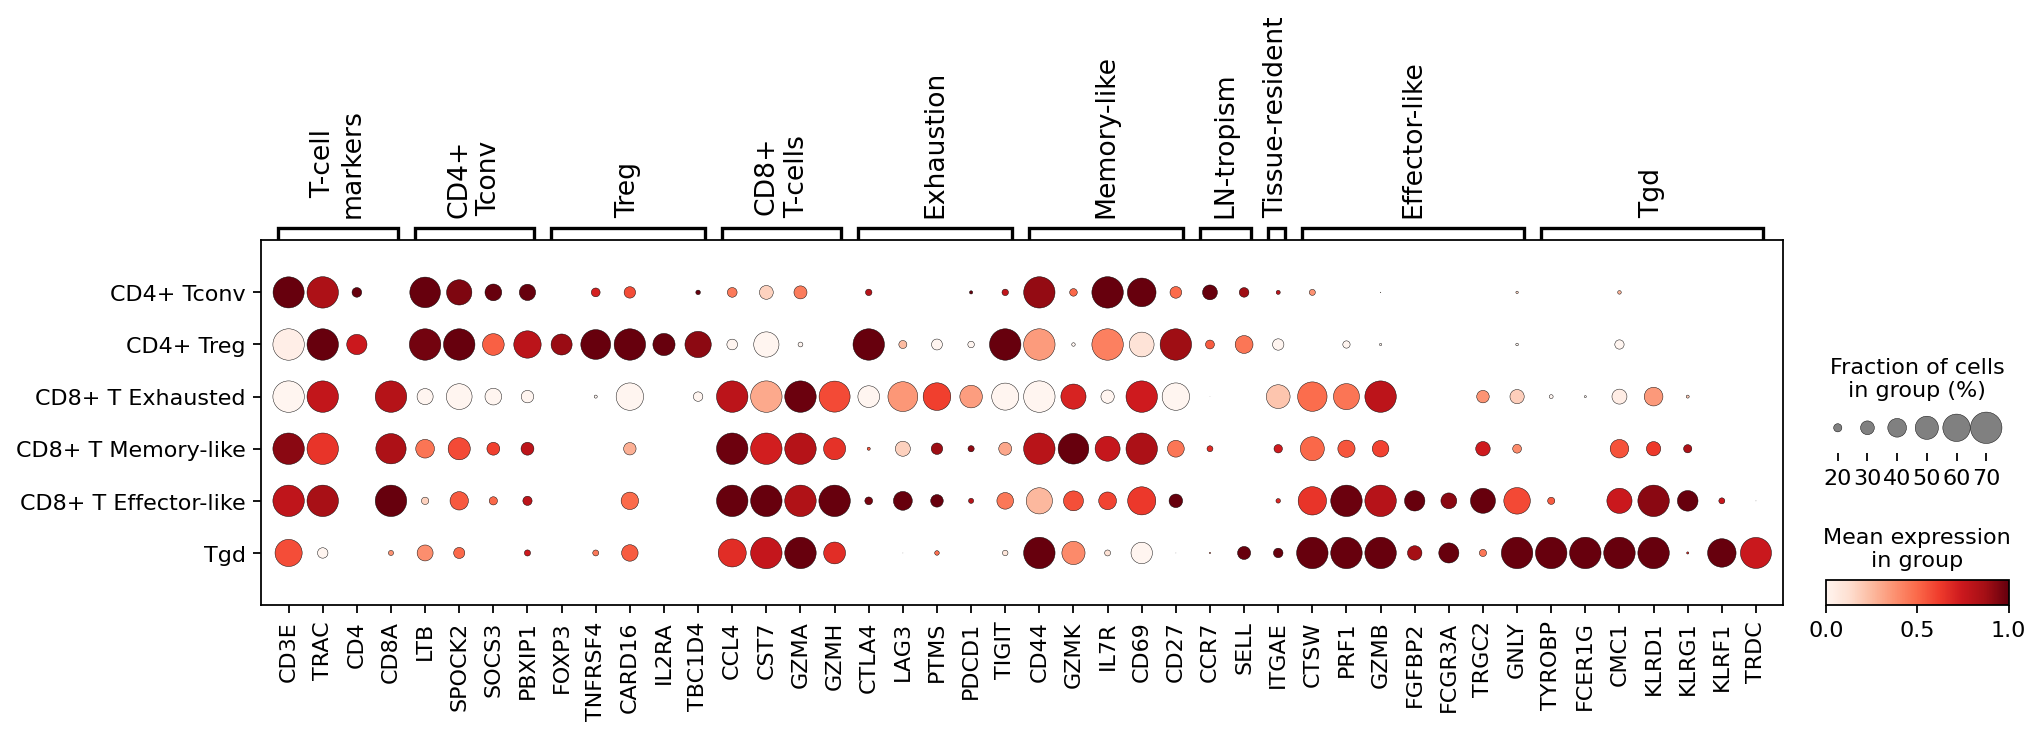

In [14]:
# By unsupervised clusters (shared phenotypic variations across celltypes)
import itertools
ax = sc.pl.dotplot(adata, gene_list, groupby='cell_type', dendrogram=False, 
                   var_group_positions=ct_pos, 
                   mean_only_expressed = True,
                   dot_max = 0.7,
                   vmax = 1,
                   dot_min = 0.1,
                   expression_cutoff = 0.3,
                   standard_scale = 'var',
                   use_raw = False, layer = 'log2(X+0.1)',
                   var_group_labels=list(ct_dict.keys()),
                   figsize=(14,3)) 



### Figure S6F

In [80]:
A = adata.obsm['nmf_cell_loadings'] 

In [81]:
A = np.log2(A+0.0001)

In [82]:
A = zscore(A, axis=0)

In [83]:
A =  pd.DataFrame(A, index = adata.obs.index)

In [84]:
factors_interest = {4: 'Tregs',
                    7: 'Exhausted',
                    12: 'Memory-like',
                    19: 'Tconv',
                    23: 'Tconv',
                    28: 'Effector-like',
                    29: 'Tgd'
                   }


In [85]:
A2 = A.loc[:,factors_interest.keys()]
A2.columns = ['NMF %d: %s' % x for x in factors_interest.items()] 

In [86]:
import seaborn as sns

In [87]:
adata.obs['cell_type2'] = adata.obs['cell_type'].str.replace('T Effector-like','Teff').str.replace('T Memory-like','Tmem').str.replace('T Exhausted','Texh')

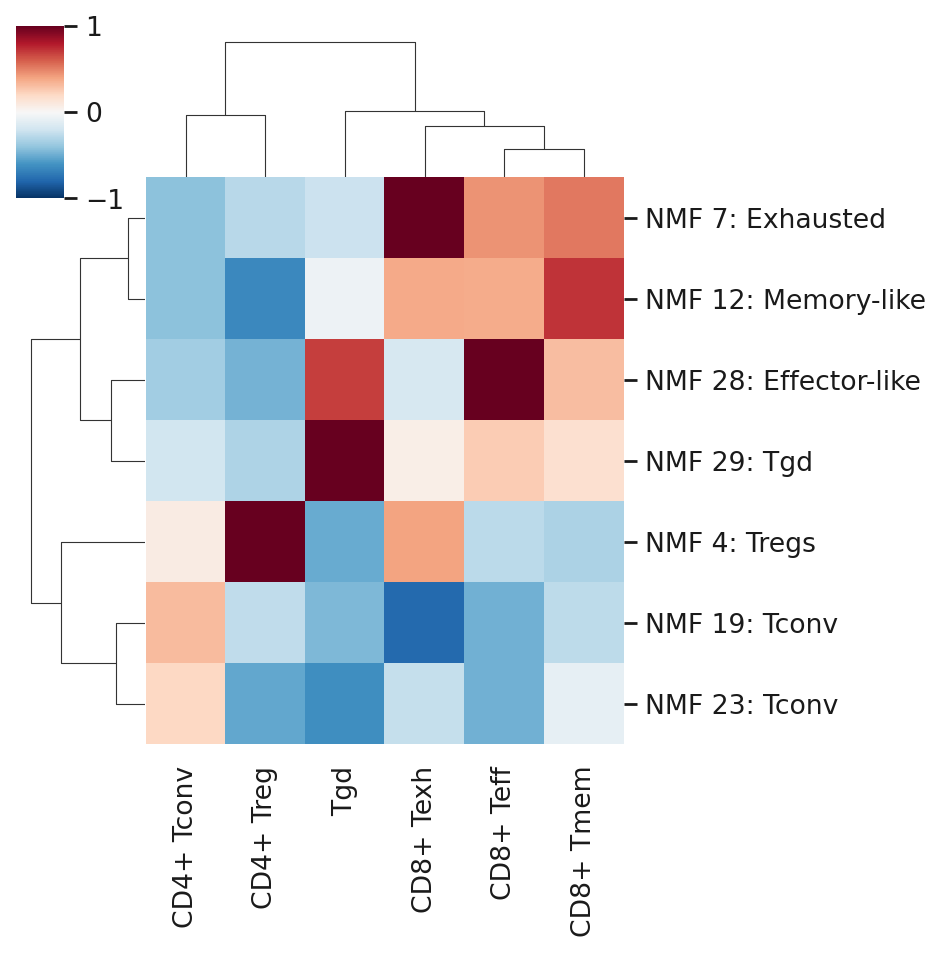

In [88]:
cm = sns.clustermap(A2.groupby(adata.obs['cell_type2'].values).mean().T,
               cmap = 'RdBu_r',
              vmax = 1, vmin = -1,
               col_cluster=True,
              figsize = (6,6),
                    metric='correlation'
             )



In [89]:
adata.obs['cell_type_cluster2'] = ['%s: %s ' % tuple(i.split('_')[::-1]) for i in adata.obs['cell_type_cluster']]
adata.obs['cell_type_cluster2'] = adata.obs['cell_type_cluster2'].str.replace('T Effector-like','Teff').str.replace('T Memory-like','Tmem').str.replace('T Exhausted','Texh')

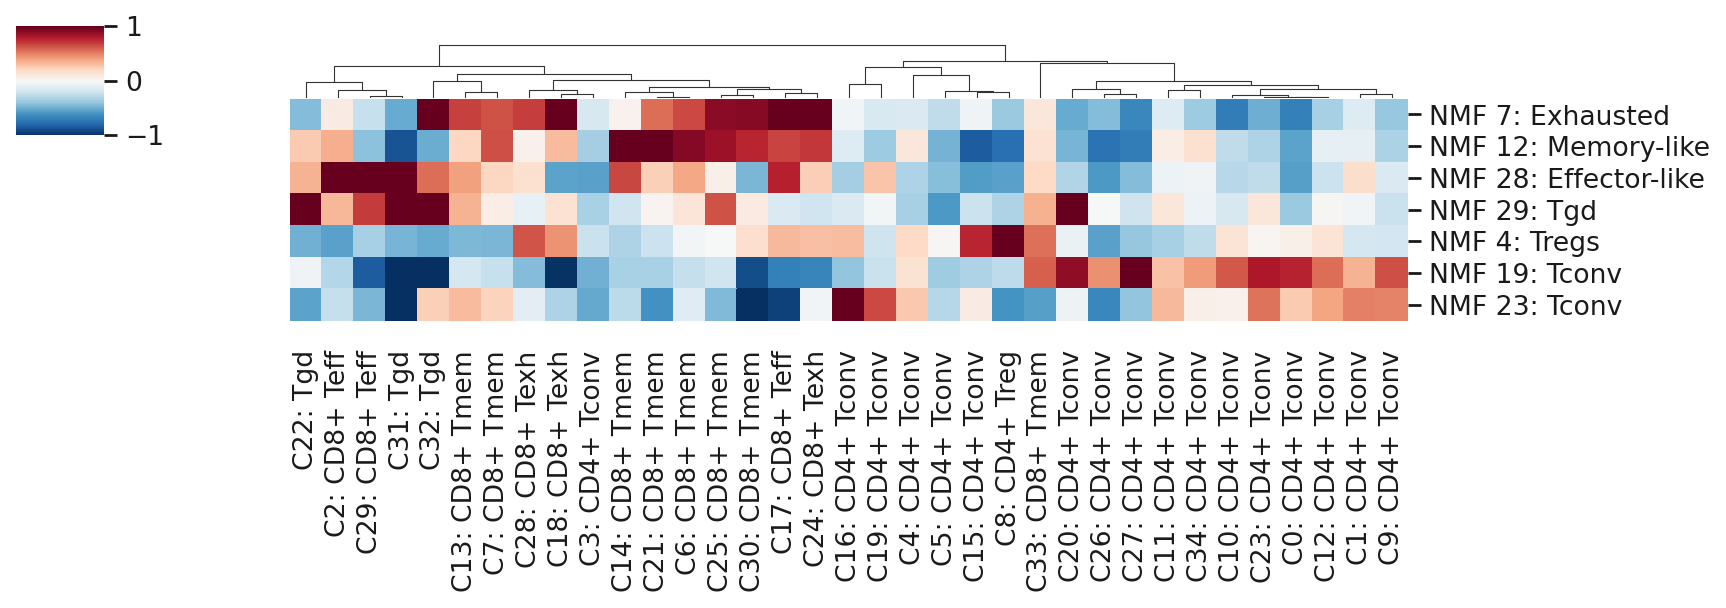

In [90]:
cm = sns.clustermap(A2.groupby(adata.obs['cell_type_cluster2'].values).mean().T,
               cmap = 'RdBu_r',
              vmax = 1, vmin = -1,
               col_cluster=True,
              figsize = (11,3.8), 
                    metric='correlation'
             )
cm.ax_row_dendrogram.set_visible(False)


### Figure S6G

In [91]:
A = pd.DataFrame(adata.obsm['nmf_cell_loadings'], index = adata.obs.index)

In [92]:
A = np.log2(A+0.0001)

In [93]:
A = A - A.min(axis=0)

In [94]:
A = A.div(A.std(axis=0))

In [95]:
A = A.loc[:,factors_interest.keys()]
A.columns = ['Factor %d: %s' % x for x in factors_interest.items()]


In [96]:
from copy import deepcopy 

In [97]:
plot_df = deepcopy(A)
plot_df.loc[:,'batch'] = adata.obs.batch
plot_df.loc[:,'subtype'] = adata.obs.histology_subtype
plot_df.loc[:,'cell_type'] = adata.obs.cell_type

In [98]:
plot_df = plot_df.loc[plot_df.subtype!='SCLC-P',:]
plot_df.subtype = plot_df.subtype.astype(str).str.replace('normal','Normal')
plot_df.subtype = plot_df.subtype.astype('category').cat.reorder_categories(['Normal','LUAD','SCLC-A','SCLC-N'])

In [99]:
plot_df2 = plot_df.melt(['subtype','cell_type','batch']).rename(columns={'variable': 'NMF'})

In [100]:
plot_df2.NMF = plot_df2.NMF.str.replace(': ',':\n')

In [101]:
ind3 = plot_df2.subtype.str.contains('SCLC')
plot_df3 = plot_df2.loc[ind3.values,:]

In [102]:
plot_df3.batch = plot_df3.batch.astype(str).astype('category')
plot_df3.subtype = plot_df3.subtype.astype(str).astype('category')

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [103]:
sns.set_style('ticks')

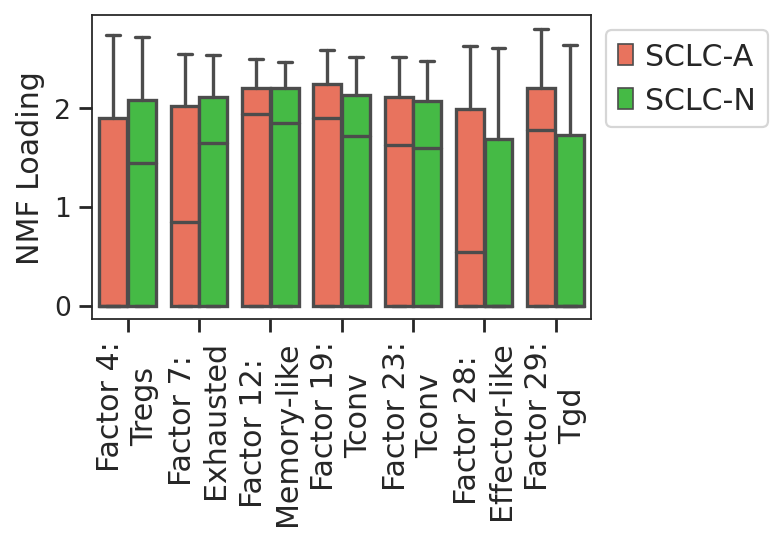

In [104]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
sns.boxplot(data=plot_df3, 
            x = 'NMF', y='value', hue = 'subtype', ax=ax,
          palette=['tomato','limegreen'])
ax.set_ylabel('NMF Loading', fontsize=13.5)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize=13.5)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=13.5)

### Figure S6I

In [105]:
proportions_ct_fine['CD8+ T cells'] = proportions_ct_fine.loc[:,['CD8+ T Effector-like',
                                                                 'CD8+ T Exhausted',
                                                                 'CD8+ T Memory-like']].sum(axis=1)


In [106]:
from statsmodels.stats.weightstats import ttest_ind


In [107]:
X = pd.DataFrame(np.log2((proportions_ct_fine.loc[:,'CD4+ Treg']/
                          proportions_ct_fine.loc[:,'CD8+ T cells']))).fillna(0)
y = pd.DataFrame(np.log2((proportions_ct_fine.loc[:,'CD8+ T cells']/
                          (proportions_ct_fine.loc[:,'CD4+ Treg'])))).fillna(0)
cov = pd.get_dummies(sample_covariates[['treatment','tissue']])[['treatment_Platinum Doublet',
                                                                 'treatment_Platinum Doublet,Immunotherapy',
                                                                 'treatment_TMZ','tissue_LN', 'tissue_distant']]
x_res, y_res = regress_cov(X,y,cov)

In [108]:
# Weighted t-test on covariate adjusted CD8+ T cell/Treg ratio
ratio = pd.DataFrame(y_res.values.T[0])
ratio['subtype'] = sample_covariates['histology_subtype'].values
ratio.index = sample_covariates.index

samples_a = sample_covariates.index[sample_covariates.histology_subtype=='SCLC-A']
samples_n = sample_covariates.index[sample_covariates.histology_subtype=='SCLC-N']

num_samples_a, num_samples_n = len(samples_a), len(samples_n)
num_cells_a, num_cells_n = adata.obs.batch.isin(samples_a).sum(), adata.obs.batch.isin(samples_n).sum()

weights_a = pd.DataFrame((pd.DataFrame(adata.obs['batch'].value_counts()).loc[samples_a].values \
                          * num_samples_a / num_cells_a).T[0], 
                         index = samples_a)
weights_n = pd.DataFrame((pd.DataFrame(adata.obs['batch'].value_counts()).loc[samples_n].values \
                          * num_samples_n / num_cells_n).T[0], 
                         index = samples_n)

_,pval,_ = ttest_ind(ratio[0][ratio['subtype']=='SCLC-A'].values,
                     ratio[0][ratio['subtype']=='SCLC-N'].values, alternative='larger', 
                     usevar='unequal', 
                     weights = (weights_a.loc[ratio.index[ratio['subtype']=='SCLC-A']][0].values,
                                weights_n.loc[ratio.index[ratio['subtype']=='SCLC-N']][0].values))


/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(array([0, 1]), [Text(0, 0, 'SCLC-A'), Text(1, 0, 'SCLC-N')])

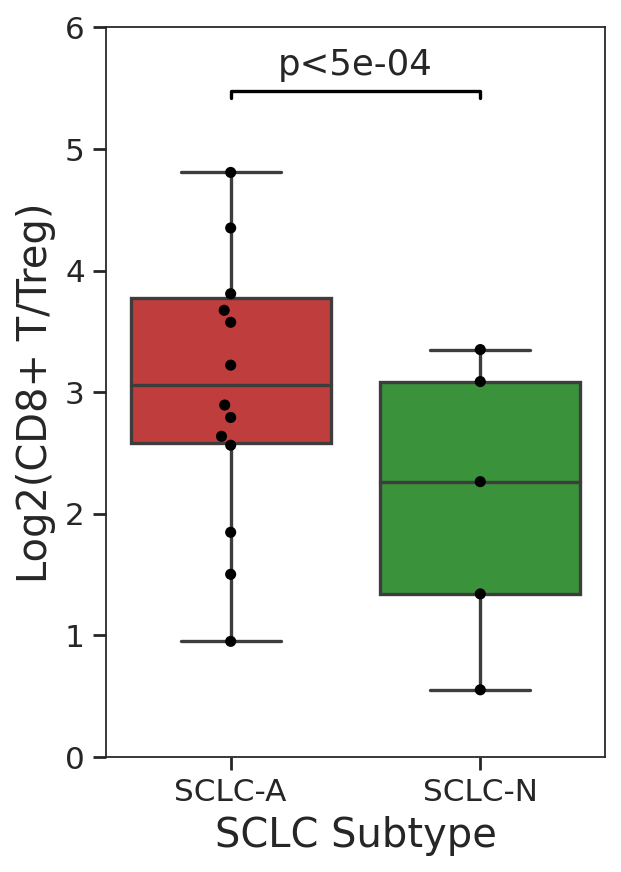

In [109]:
y = pd.DataFrame(np.log2((proportions_ct_fine.loc[:,'CD8+ T cells'] / 
                          (proportions_ct_fine.loc[:,'CD4+ Treg'])).astype(np.float))).astype(np.float).fillna(0)
plt.rcParams['figure.figsize'] = [4, 6]
ratio = pd.DataFrame(y.values.T[0])
ratio['subtype'] = sample_covariates['histology_subtype'].values
ratio.index = sample_covariates.index
ratio = ratio.loc[ratio.subtype!='SCLC-P',:]

sns.boxplot(y = 0, x = 'subtype', data = ratio, palette = ['tab:red','tab:green'])
sns.swarmplot(y = 0, x = 'subtype', data = ratio, color = 'black')
plt.ylim(0,6)
plt.text(0.5, 5.55, 'p<{:.0e}'.format(pval), ha='center', va='bottom',fontsize=16)
plt.plot([0,0,1,1], [5.42,5.48,5.48,5.42], lw=1.5, color = 'black')
plt.ylabel('Log2(CD8+ T/Treg)', fontsize = 18)
plt.xlabel('SCLC Subtype',fontsize=18)
plt.yticks(size = 14)
plt.xticks(size = 14)
